### Cell painting Visualizations

- Median score Visualization
- P-value visualization
- Replicate vs Non-replicate visualization
- MAS and Signature strength visualization

In [1]:
import re
import os
import sys
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
sns.set_style("darkgrid")
sns.set_context("talk")

sys.path.append("../../scripts")
from define_edge_wells import get_edge_wells

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

### - Visualization of p-values vs median scores for each MOAs per dose

In [2]:
dose_recode_info = {
    1: '0.04 uM', 2:'0.12 uM', 3:'0.37 uM',
    4: '1.11 uM', 5:'3.33 uM', 6:'10 uM'
}

# Define edge wells
edge_wells = get_edge_wells()

In [3]:
results_dir = pathlib.Path("../results")

In [4]:
cp_level4_path = 'cellpainting_lvl4_cpd_replicate_datasets'

# Run using either "_edgewell_filter" or ""
cp_edge_filter_indicator = "_edgewell_filter"

In [5]:
df_cpd_median_scrs = pd.read_csv(os.path.join(cp_level4_path, 'cpd_replicate_median_scores.csv'))
df_null_p_vals = pd.read_csv(os.path.join(cp_level4_path, f'cpd_replicate_p_values{cp_edge_filter_indicator}.csv'))

In [6]:
# Common compounds
common_file = pathlib.Path("..", "..", "..", "6.paper_figures", "data", "significant_compounds_by_threshold_both_assays.tsv.gz")
common_df = pd.read_csv(common_file, sep="\t")

common_compounds = common_df.compound.unique()

# Subset to compounds measured outside edge wells, if applicable
if cp_edge_filter_indicator == "_edgewell_filter":
    common_compounds = list(set(common_compounds).intersection(set(df_null_p_vals.cpd.unique().tolist())))
    
print(len(common_compounds))

1095


In [7]:
# Subset to common compound measurements
df_cpd_median_scrs = df_cpd_median_scrs.loc[df_cpd_median_scrs.cpd.isin(common_compounds), :]

In [8]:
df_level4 = pd.read_csv(os.path.join(cp_level4_path, 'cp_level4_cpd_replicates.csv.gz'), 
                        compression='gzip',low_memory = False)

if cp_edge_filter_indicator == "_edgewell_filter":
    df_level4 = df_level4.query("Metadata_Well not in @edge_wells").reset_index(drop=True)
    
with open(os.path.join(cp_level4_path, f'null_distribution{cp_edge_filter_indicator}.pickle'), 'rb') as handle:
    null_distribution_replicates = pickle.load(handle)
    
with open(os.path.join(cp_level4_path, f'null_dist_medians_per_dose{cp_edge_filter_indicator}.pickle'), 'rb') as handle:
    null_dist_med_cp = pickle.load(handle)

In [9]:
df_all_scores = pd.read_csv(os.path.join(cp_level4_path, 'cp_all_scores.csv'))

with open(os.path.join(cp_level4_path, 'CP_dmso_95_percentile_MAS.pickle'), 'rb') as handle:
    dmso_95_pctile = pickle.load(handle)

In [10]:
def rename_cols(df):
    'Rename columns from dose number to actual doses'
    
    df.rename(columns= {'dose_1' : '0.04 uM', 'dose_2':'0.12 uM', 'dose_3':'0.37 uM',
                        'dose_4': '1.11 uM', 'dose_5':'3.33 uM', 'dose_6':'10 uM'}, inplace = True)
    return df

In [11]:
df_cpd_median_scores = rename_cols(df_cpd_median_scrs.copy())
df_null_p_vals = rename_cols(df_null_p_vals)

In [12]:
def melt_df(df, col_name):
    """
    This function returns a reformatted dataframe with 
    3 columns: cpd, dose number and dose_values(median score or p-value)
    """
    df = df.melt(id_vars=['cpd', 'no_of_replicates'], var_name="dose", value_name=col_name)
    return df

In [13]:
def merge_p_median_vals(df_cpd_vals, df_null):
    """
    This function merge p_values and median scores 
    dataframes for each compound for all doses(1-6) 
    """
    df_p_vals = melt_df(df_null, 'p_values')
    df_cpd_vals = melt_df(df_cpd_vals, 'median_scores')
    df_cpd_vals['p_values'] = df_p_vals['p_values']
    return df_cpd_vals

In [14]:
def plot_p_vs_median(df, path, file_name):
    
    """plot p_values vs median correlation scores for each compound for all doses (1-6)"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(12,8)) 
    plt.xlabel("Median scores of pairwise correlation btw cpds")
    plt.ylabel("Non-parametric P-values")
    plt.title("P-values vs median scores for compound replicates")
    fig = sns.scatterplot(data=df, x="median_scores", y="p_values", hue="dose", 
                          style="dose", palette = "viridis")
    fig.axhline(0.05, ls='--', c='black')
    fig.legend(loc = 'upper right')
    fig.text(-0.18,0.07, "Significance level (0.05)")
    plt.savefig(os.path.join(path, file_name))
    plt.show()

In [15]:
df_medians_p_vals = merge_p_median_vals(df_cpd_median_scores, df_null_p_vals)

In [16]:
df_medians_p_vals.head()

,cpd,no_of_replicates,dose,median_scores,p_values
0,17-hydroxyprogesterone-caproate,5,0.04 uM,0.054557,0.001
1,2-iminobiotin,5,0.04 uM,0.053791,0.001
2,3-amino-benzamide,5,0.04 uM,0.111933,0.000
3,3-deazaadenosine,5,0.04 uM,0.015754,0.195
4,abacavir,5,0.04 uM,0.015678,0.199


|dose value(uM)| Dose |
|  :--------:  | :--: |
| ~0.04 | 1 |
| ~0.12 | 2 |
| ~0.37 | 3 |
| ~1.11 | 4 |
| ~3.33 | 5 |
| ~10 | 6 |

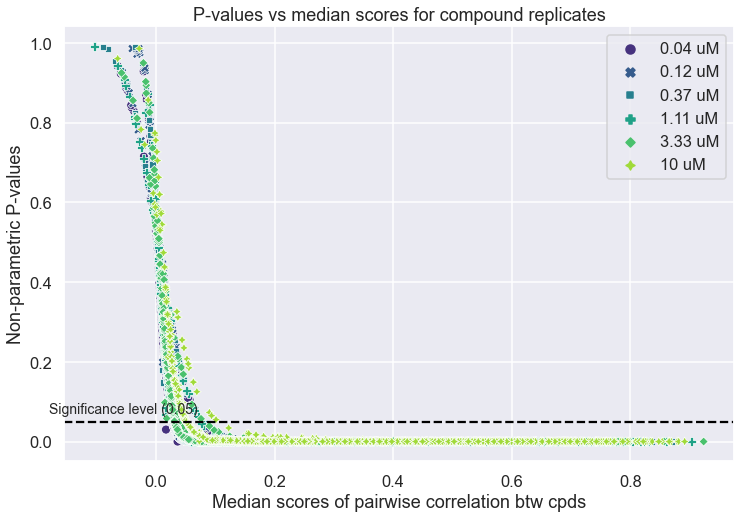

In [17]:
plot_p_vs_median(df_medians_p_vals, 'cellpainting_figures', f'p_vs_median{cp_edge_filter_indicator}.png')

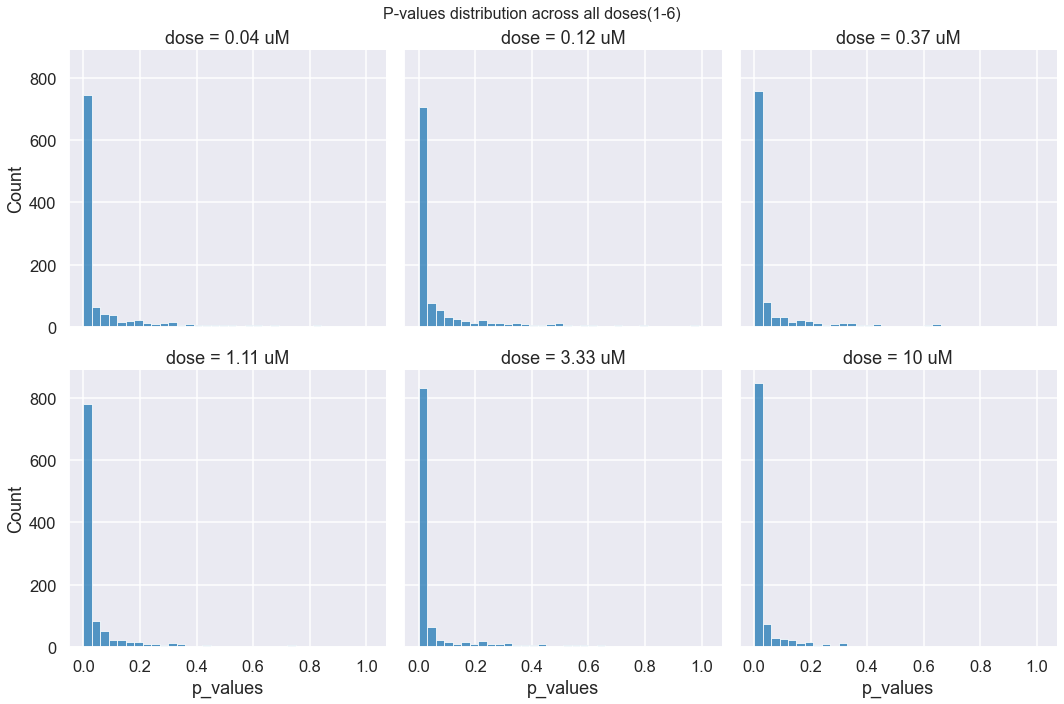

In [18]:
def plot_p_value_dist(df, path, file_name):
    """Plot p-values distribution"""
    if not os.path.exists(path):
        os.mkdir(path)  
    dis_plt = sns.displot(df, x="p_values", col="dose", col_wrap=3, binwidth=0.03)
    dis_plt.fig.suptitle("P-values distribution across all doses(1-6)", size = 16)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_p_value_dist(df_medians_p_vals, 'cellpainting_figures', f'p_value_distribution{cp_edge_filter_indicator}.png')

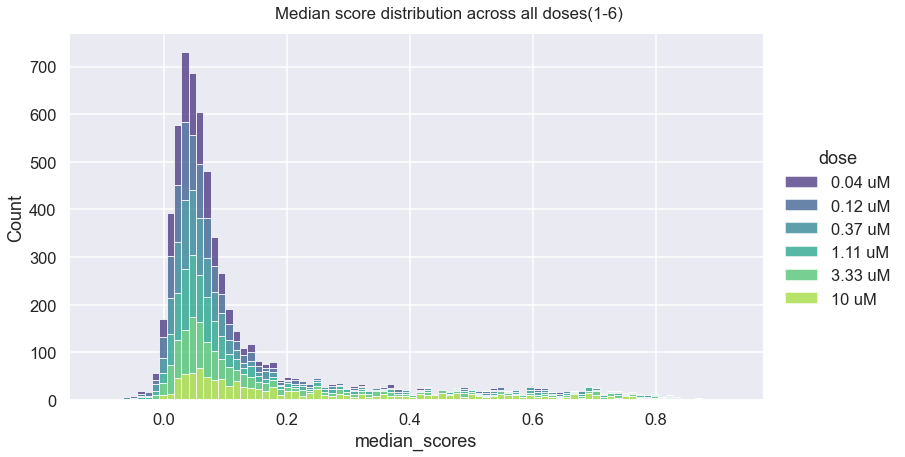

In [19]:
def plot_median_score_distribution(df, title, path, file_name):
    
    if not os.path.exists(path):
        os.mkdir(path)
        
    dis_plt = sns.displot(df, x="median_scores", hue="dose", kind="hist", 
                          multiple="stack", palette = 'viridis', height=6.5, aspect=1.7)
    dis_plt.fig.suptitle(title)
    dis_plt.fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()
    
plot_median_score_distribution(df_medians_p_vals, "Median score distribution across all doses(1-6)",
                               'cellpainting_figures', f'median_score_distribution{cp_edge_filter_indicator}.png')

### - Replicate versus Non-replicate distribution across all doses (1-6)

In [20]:
def get_replicate_score(cpds_list, df):
    
    """
    This function computes the spearman replicate correlation scores 
    between replicates for all compounds
    """
    cpds_replicate_score = []
    for cpd in cpds_list:
        cpd_replicates = df[df['pert_iname'] == cpd].copy()
        cpd_replicates.drop(['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_dose_recode', 'Metadata_Plate', 
                             'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 'broad_id', 
                             'pert_iname', 'moa', 'replicate_name'], axis = 1, inplace = True)
        cpd_replicates_corr = cpd_replicates.astype('float64').T.corr(method = 'spearman').values
        cpds_replicate_score += list(cpd_replicates_corr[np.triu_indices(len(cpd_replicates_corr), k = 1)])
    return cpds_replicate_score

In [21]:
def get_true_replicate_score(df, df_lvl4):
    
    """This function gets the true spearman percentile correlation scores for all compounds across all doses (1-6)"""
    
    dose_list = list(set(df_lvl4['Metadata_dose_recode'].unique().tolist()))[1:7]
    cpd_sizes =  df['no_of_replicates'].unique().tolist()
    df = df.set_index('cpd').rename_axis(None, axis=0)
    true_replicates = {}
    for dose in dose_list:
        rep_list = []
        df_dose = df_lvl4[df_lvl4['Metadata_dose_recode'] == dose].copy()
        for keys in cpd_sizes:
            cpds_keys = df[df['no_of_replicates'] == keys].index
            replicates_vals = get_replicate_score(cpds_keys, df_dose)
            rep_list += replicates_vals
        true_replicates[dose] = rep_list
    return true_replicates

In [22]:
true_replicates = get_true_replicate_score(df_cpd_median_scores, df_level4)

In [23]:
def get_random_replicate_score(random_rep_list, df):
    
    """This function computes the spearman correlation scores between random replicates"""
    
    df_dose_ = df.set_index('replicate_name').rename_axis(None, axis=0)
    df_dose_.drop(['Metadata_broad_sample', 'Metadata_pert_id', 'Metadata_dose_recode', 'Metadata_Plate', 
                   'Metadata_Well', 'Metadata_broad_id', 'Metadata_moa', 
                   'broad_id', 'pert_iname', 'moa'], axis = 1, inplace = True)
    rep_corr_list = []
    for rep_list in random_rep_list:
        df_reps = df_dose_.loc[rep_list].copy()
        reps_corr = df_reps.astype('float64').T.corr(method = 'spearman').values
        rep_corr_list += list(reps_corr[np.triu_indices(len(reps_corr), k = 1)])
    return rep_corr_list

In [24]:
def get_rand_replicate_corr(df_lvl4, null_dist):
    """
    This function gets spearman correlation values 
    between randomly selected replicates across all doses (1-6)
    
    Returns a dictionary, with the dose number as the keys and 
    all the correlation scores between randomly selected replicates 
    as the values
    """
    dose_list = list(set(df_lvl4['Metadata_dose_recode'].unique().tolist()))[1:7]
    random_replicates = {}
    for dose in dose_list:
        rep_list = []
        df_dose = df_lvl4[df_lvl4['Metadata_dose_recode'] == dose].copy()
        for key in null_dist:
            rand_rep_list = null_dist[key][dose-1]
            rep_list += get_random_replicate_score(rand_rep_list, df_dose)
        random_replicates[dose] = rep_list
    return random_replicates

In [25]:
random_replicates = get_rand_replicate_corr(df_level4, null_distribution_replicates)

In [26]:
def transform_dataframe(rep, rep_name):
    """
    Transforms replicate correlation dataframe to have 3 columns: 
    dose, correlation_values and type of replicates
    """
    df_reps = pd.DataFrame.from_dict(rep, orient='index').T
    rep_melt = df_reps.melt(var_name="dose", value_name="correlation_values")
    rep_melt['type'] = rep_name
    return rep_melt

In [27]:
df_true_rep = transform_dataframe(true_replicates, 'true replicate')
df_rand_rep = transform_dataframe(random_replicates, 'non replicate')

In [28]:
null_percent_replicating_score_df = transform_dataframe(null_dist_med_cp, "non_replicate").assign(assay="Cell Painting")
null_percent_replicating_score_df.dose = null_percent_replicating_score_df.dose.replace(dose_recode_info)

output_file = pathlib.Path(f"{results_dir}/cell_paintint_percent_replicating_data_null_distribution{cp_edge_filter_indicator}.tsv.gz")
null_percent_replicating_score_df.to_csv(output_file, sep="\t", index=False)

print(null_percent_replicating_score_df.shape)
null_percent_replicating_score_df.head()

(24000, 4)


,dose,correlation_values,type,assay
0,0.04 uM,0.006218,non_replicate,Cell Painting
1,0.04 uM,0.005048,non_replicate,Cell Painting
2,0.04 uM,-0.001238,non_replicate,Cell Painting
3,0.04 uM,-0.015645,non_replicate,Cell Painting
4,0.04 uM,0.013208,non_replicate,Cell Painting


In [29]:
def plot_replicate_vs_non_replicate(df_true, df_rand, title, path, file_name):
    """Plot replicate vs non-replicate correlation values distribution across all doses"""
    
    if not os.path.exists(path):
        os.mkdir(path)
    fig, axes = plt.subplots(ncols=3, nrows=2)
    fig.set_size_inches(18.7, 12.27)
    labels = ['Non-replicate', 'Replicate']
    
    for i, ax in zip(range(1,7), axes.flat):
        sns.distplot(df_rand[df_rand['dose'] == i]["correlation_values"], hist=True,ax=ax)
        sns.distplot(df_true[df_true['dose'] == i]["correlation_values"], hist=True,ax=ax)
        ax.legend(labels, loc="upper right", fontsize='small')
        
    [axes[0][idx].set_title("Dose = " + dose) for idx, dose in enumerate(['0.04 uM', '0.12 uM', '0.37 uM'])]
    [axes[1][idx].set_title("Dose = " + dose) for idx, dose in enumerate(['1.11 uM', '3.33 uM', '10 uM'])]
    [axes[0][i].set_xlabel("") for i in range(0, 3)]
    [axes[0][i].set_ylabel("") for i in range(1, 3)]
    [axes[1][i].set_ylabel("") for i in range(1, 3)]
    fig.suptitle(title)
    fig.subplots_adjust(top=.92)
    plt.savefig(os.path.join(path, file_name))
    plt.show()

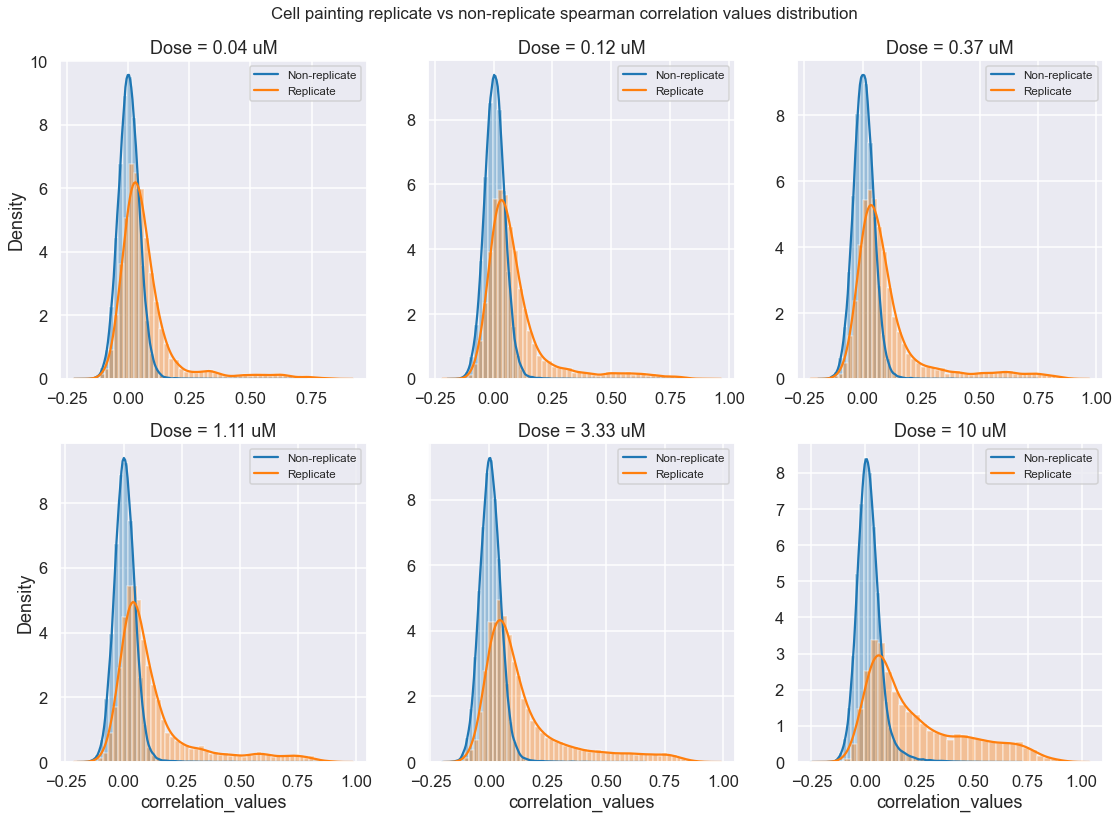

In [30]:
plot_replicate_vs_non_replicate(df_true_rep, df_rand_rep, 
                                "Cell painting replicate vs non-replicate spearman correlation values distribution", 
                                'cellpainting_figures', f'replicate_non_replicate_dist{cp_edge_filter_indicator}.png')

In [31]:
full_cor_df = pd.concat([df_true_rep, df_rand_rep], axis="rows").reset_index(drop=True).dropna()

full_cor_df.dose = full_cor_df.dose.replace(dose_recode_info)

print(full_cor_df.shape)

output_file = pathlib.Path(f"{results_dir}/cell_painting_pairwise_correlation_distribution{cp_edge_filter_indicator}.tsv.gz")
full_cor_df.to_csv(output_file, sep="\t", index=False)

(429303, 3)


### - Compounds with statistically significant p-values i.e. their replicate median correlation values can be reproducible

In [32]:
def reproducible_dose(df):
    """
    This function computes how many doses each compound 
    has reproducible median correlation score in, (out of the 6 doses based on p values)
    """
    df_new = df.set_index('cpd').rename_axis(None, axis=0).drop(['no_of_replicates'], axis = 1).copy()
    cpd_values = {cpd:sum(df_new.loc[cpd] <= 0.05) for cpd in df_new.index}
    df['No_of_reproducible_doses'] = cpd_values.values()
    
    return df

In [33]:
df_cp_pvals = reproducible_dose(df_null_p_vals)
df_all_scores = df_all_scores.merge(df_cp_pvals[['cpd', 'no_of_replicates', 'No_of_reproducible_doses']], on=['cpd'])

In [34]:
stat_cpds = df_cp_pvals[df_cp_pvals['No_of_reproducible_doses'] == 6]['cpd'].values.tolist()

In [35]:
df_stat_vals = df_all_scores.loc[df_all_scores['cpd'].isin(stat_cpds)].reset_index(drop=True)

In [36]:
df_stat_p = df_stat_vals[['cpd', 'dose', 'replicate_correlation']].rename({'replicate_correlation':'median_scores'}, 
                                                                          axis = 1)

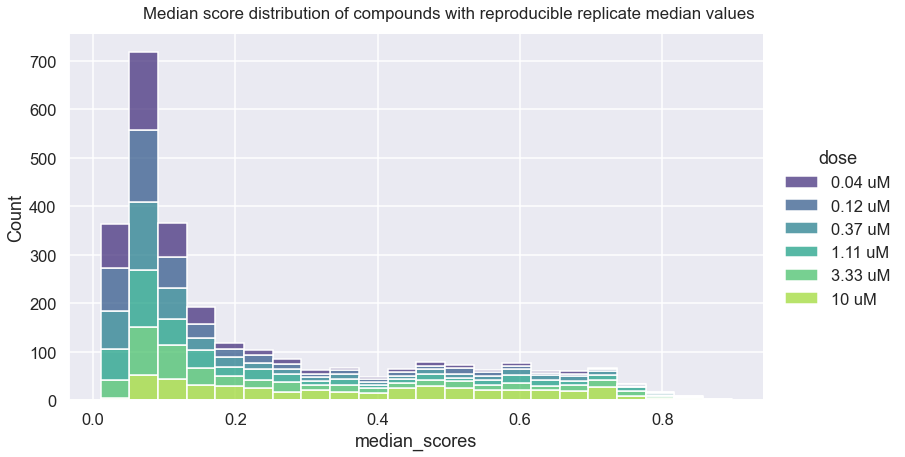

In [37]:
plot_median_score_distribution(df_stat_p, 
                               "Median score distribution of compounds with reproducible replicate median values",
                               'cellpainting_figures', f'stat_sign_median_score_dist{cp_edge_filter_indicator}.png')

**Notice that the distribution of these statistically significant median scores (i.e. reproducible, p_values < 0.05) are positive values (between ~0.2 - 0.95)**

### Visualizing TAS and signature strength scores for L1000 compounds

In [38]:
output_file = pathlib.Path(f"{results_dir}/cell_painting_percent_replicating_data{cp_edge_filter_indicator}.tsv.gz")
df_all_scores.to_csv(output_file, sep="\t", index=False)

print(df_all_scores.shape)
df_all_scores.head()

(6570, 7)


,cpd,dose,replicate_correlation,signature_strength,MAS,no_of_replicates,No_of_reproducible_doses
0,17-hydroxyprogesterone-caproate,0.04 uM,0.060655,338.6,0.160125,5,6
1,17-hydroxyprogesterone-caproate,0.12 uM,0.035172,349.6,0.123899,5,6
2,17-hydroxyprogesterone-caproate,0.37 uM,0.061980,372.4,0.169751,5,6
3,17-hydroxyprogesterone-caproate,1.11 uM,0.078039,368.2,0.189400,5,6
4,17-hydroxyprogesterone-caproate,3.33 uM,0.146046,372.4,0.260576,5,6


In [39]:
cp_95pct = [np.percentile(null_dist_med_cp[keys],95) for keys in null_dist_med_cp]

In [40]:
cp_95pct

[0.0433827677903115,
 0.044776615795111774,
 0.04493293499911317,
 0.043815849184910355,
 0.047116835726680545,
 0.06451473237663623]

In [41]:
def plot_mas_vs_corr(df, title, cp_95pct, dmso_95pct, path, file_name, alp = 0.3, size =(50,300)):
    
    """Plot morphological activity score (MAS) versus median replicate correlation"""
    
    if not os.path.exists(path):
        os.mkdir(path)   
    rel_plt = sns.relplot(data=df, x="replicate_correlation", y="MAS", col="dose", 
                          hue = 'No_of_reproducible_doses', size = 'No_of_reproducible_doses', 
                          sizes= size, kind="scatter", palette=sns.color_palette("flare", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx, val in enumerate(cp_95pct):
        rel_plt.axes[idx].axhline(y = dmso_95pct, ls='--', color = 'black', alpha = 0.7, label = '95th-DMSO MAS score')
        rel_plt.axes[idx].axvline(x = val, ls='--', color = 'red', alpha = 0.7, label = '95th null distribution')
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.95, 0.51])
    rel_plt.legend.set_title('Number of\nreproducible\ndoses')
    plt.legend(bbox_to_anchor=(1.01, 0.49), loc='lower left')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

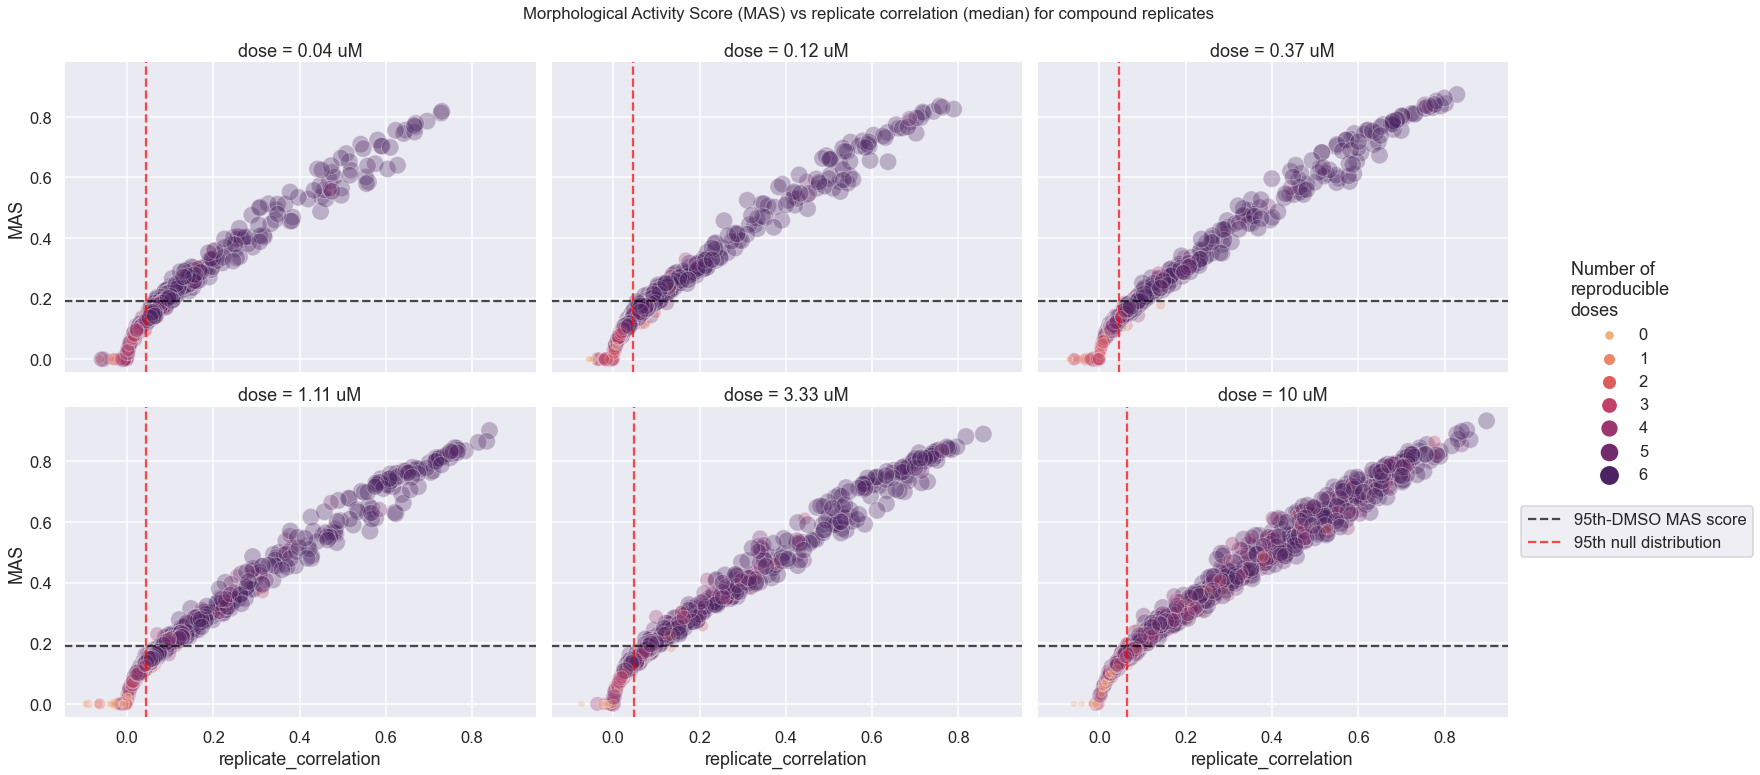

In [42]:
plot_mas_vs_corr(df_all_scores,
                 "Morphological Activity Score (MAS) vs replicate correlation (median) for compound replicates",
                 cp_95pct, dmso_95_pctile, 'cellpainting_figures', f'MAS_vs_median_corr{cp_edge_filter_indicator}.png')

In [43]:
def plot_ss_vs_corr(df, title, cp_95pct, path, file_name, alp = 0.3, size =(50,300)):
    
    """Plot signature strength versus median replicate correlation"""
    
    if not os.path.exists(path):
        os.mkdir(path)    
    rel_plt = sns.relplot(data=df, x="replicate_correlation", y="signature_strength", col="dose", 
                          hue = 'No_of_reproducible_doses', size = 'No_of_reproducible_doses', 
                          sizes= size, kind="scatter", palette=sns.color_palette("flare", as_cmap=True),
                          col_wrap=3, height=5.5, aspect=1.3, alpha = alp)
    rel_plt.fig.suptitle(title)
    rel_plt.fig.subplots_adjust(top=.91)
    for idx, val in enumerate(cp_95pct):
        rel_plt.axes[idx].axvline(x = val, ls='--', color = 'black', alpha = 0.7, label = '95th null distribution')
    rel_leg = rel_plt._legend
    rel_leg.set_bbox_to_anchor([0.95, 0.51])
    rel_plt.legend.set_title('Number of\nreproducible\ndoses')
    plt.legend(bbox_to_anchor=(1.01, 0.49), loc='lower left')
    plt.savefig(os.path.join(path, file_name))
    plt.show()

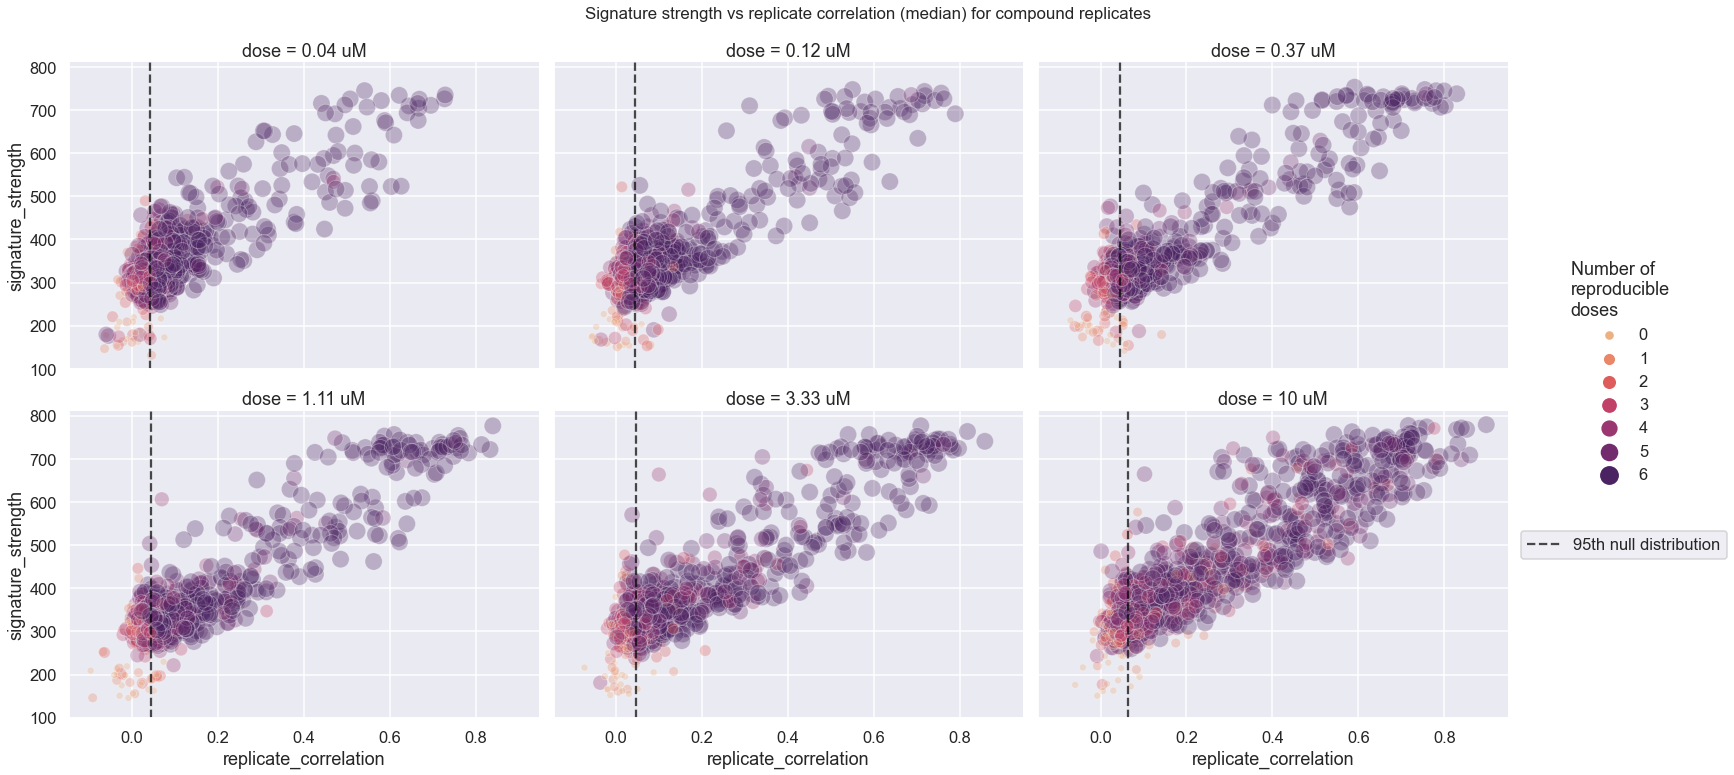

In [44]:
plot_ss_vs_corr(df_all_scores, "Signature strength vs replicate correlation (median) for compound replicates", 
                cp_95pct, 'cellpainting_figures', f'SS_vs_median_corr{cp_edge_filter_indicator}.png')

### Visualization based on reproducible median score (compounds with p-values < 0.05 across all doses)

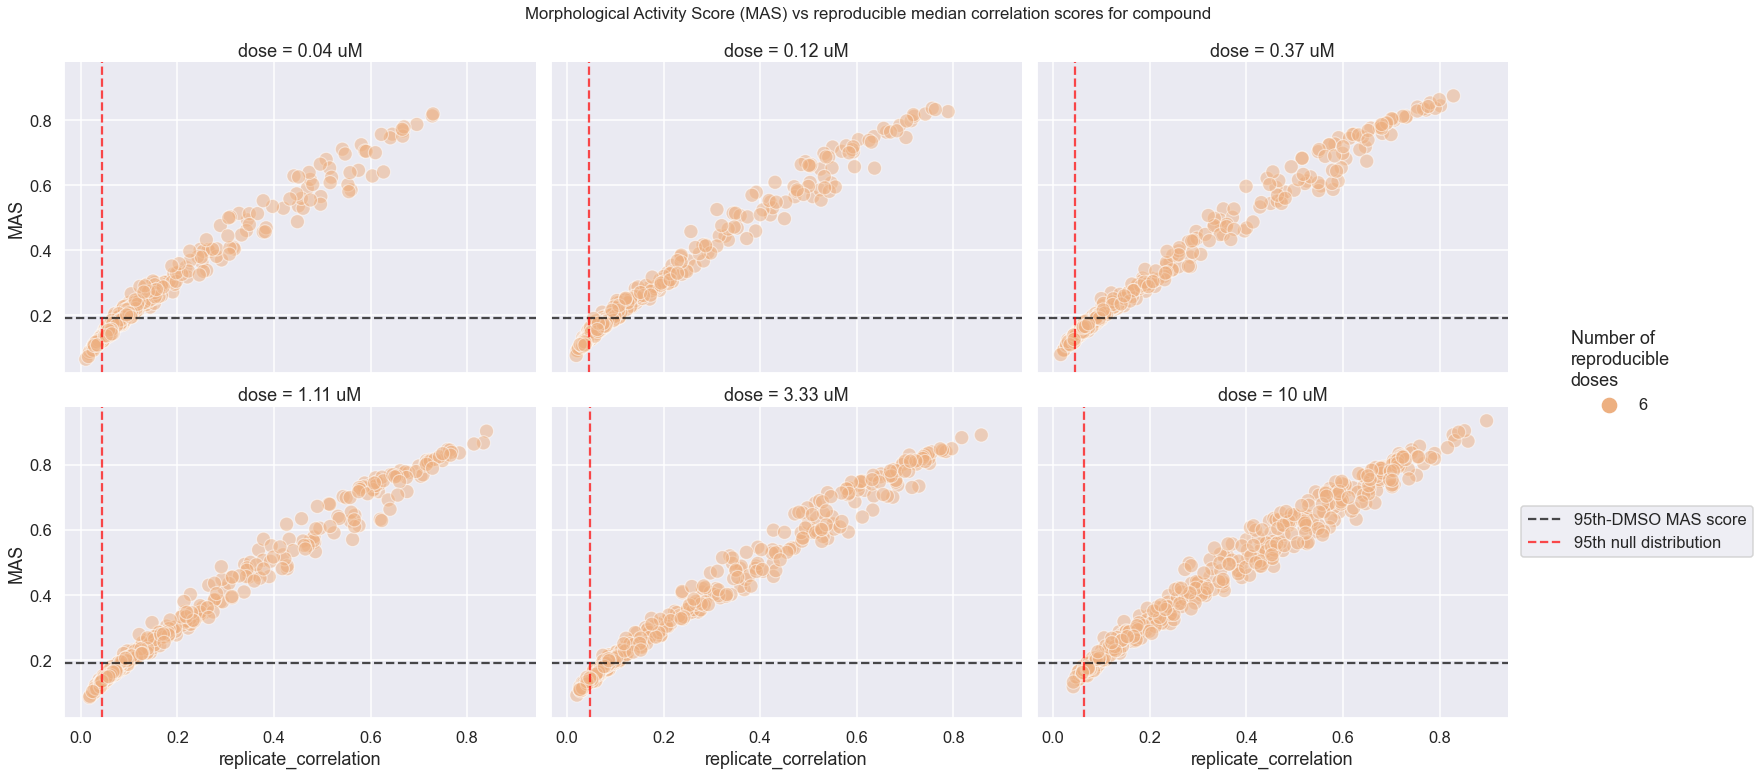

In [45]:
plot_mas_vs_corr(df_stat_vals,
                 "Morphological Activity Score (MAS) vs reproducible median correlation scores for compound",
                 cp_95pct, dmso_95_pctile, 'cellpainting_figures', f'stat_MAS_vs_median_corr{cp_edge_filter_indicator}.png', alp = 0.5, size = (200,200))

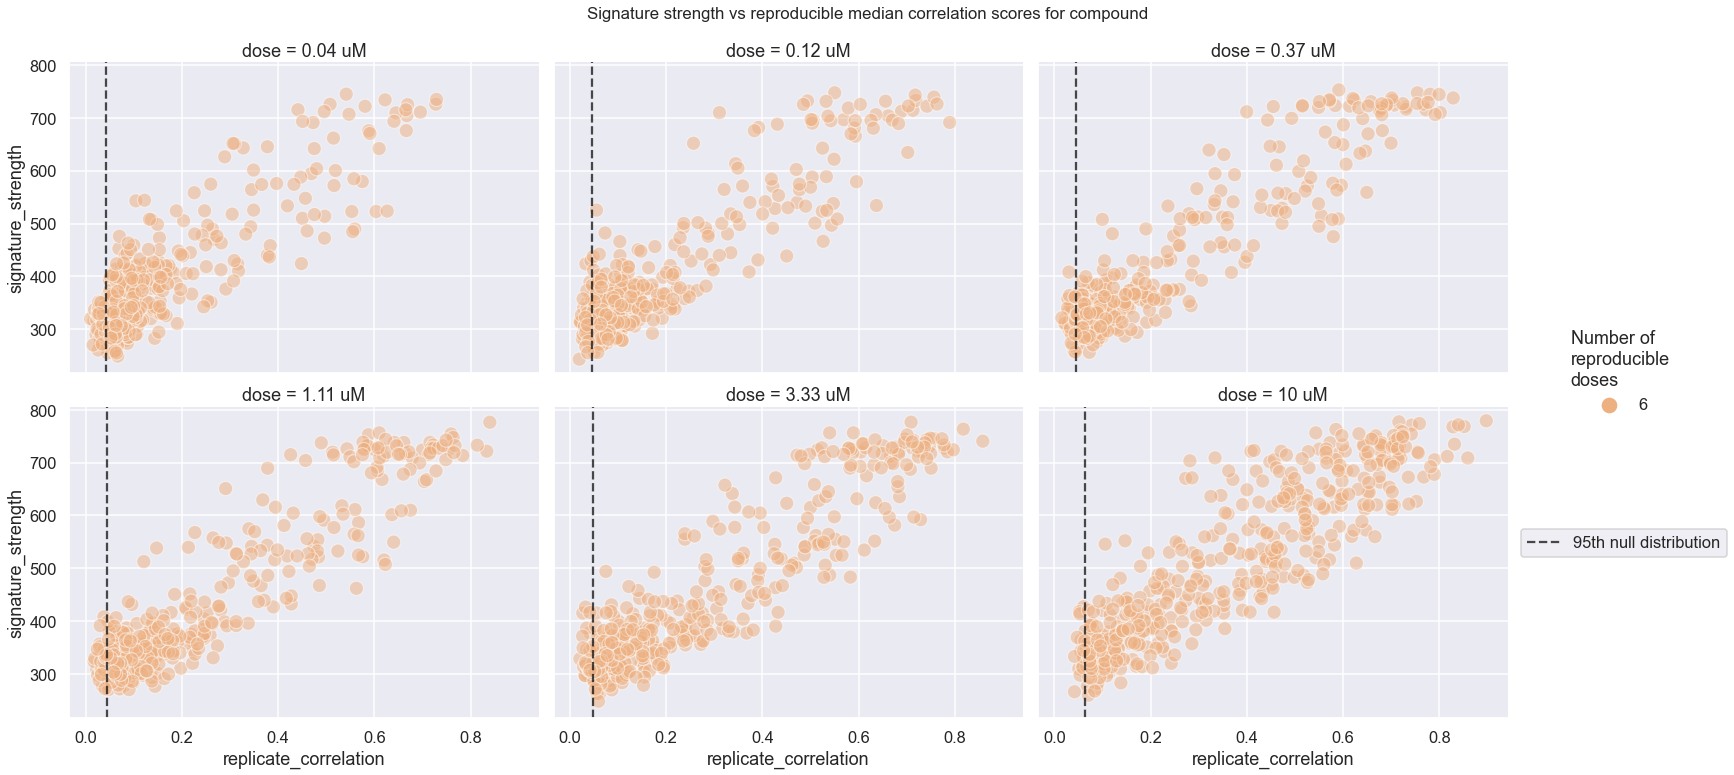

In [46]:
plot_ss_vs_corr(df_stat_vals, "Signature strength vs reproducible median correlation scores for compound", 
                cp_95pct, 'cellpainting_figures', f'stat_SS_vs_median_corr{cp_edge_filter_indicator}.png', alp = 0.5, size = (200,200))